# nSpiral Experiment 1

For this first experiment, we will evaluate the performance of all hyper-parameter optimization methods implemented in a simple context with a fixed budget of **500** evaluations. More precisely, considering a simple 2D points classification problem called nSpiral with **5** classes, **800** training points and **800** test points generated and a value of **0.40** as the standard deviation of the Gaussian noise added to the data, will we initialize a Sklearn MLP with **4** hidden layers of 20 neurons with default hyper-parameters and try to find the best values for $\alpha$ (L2 penalty (regularization term) parameter), *learning rate init* (initial learning rate used), $\beta_{1}$ (exponential decay rate for estimates of first moment vector in adam) and finaly $\beta_{2}$ (exponential decay rate for estimates of second moment vector in adam) with all methods available.

In [1]:
# Import code needed
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
module_path = os.path.join(module_path,'')
sys.path.append(module_path)
from numpy import linspace
import pickle
import DataManager as dm
import Model as mod
from HPtuner import HPtuner, ContinuousDomain, DiscreteDomain

In [2]:
# We generate data for our tests and two global variables for all test
dgen = dm.DataGenerator(800, 800, "nSpiral")
noise = 0.40
x_train, t_train, x_test, t_test = dgen.generate_data(noise, 5, seed=10512)
nb_cross_validation = 2
nb_evals = 500
dm.plot_data(x_train, t_train)

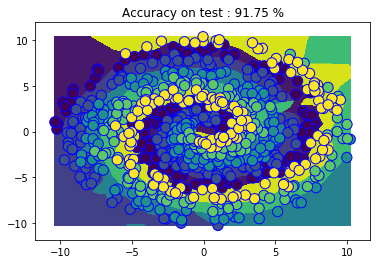

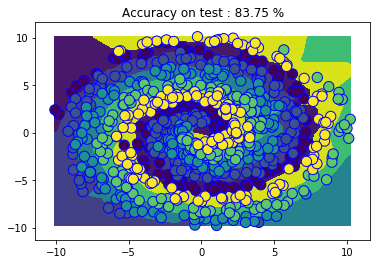

In [3]:
# We initialize an MLP with default hyper-parameters and 3 hidden layers of 20 neurons to classify our data
# and test its performance on both training and test data sets
mlp = mod.MLP((20, 20, 20,20), max_iter=1000)
mlp.fit(x_train, t_train)
mlp.plot_data(x_train, t_train)
mlp.plot_data(x_test, t_test)

## Random search

In [4]:
# We do a deep copy of our MLP for the test, set the experiment title and save the path to save the results
save = pickle.dumps(mlp)
mlp_for_rs = pickle.loads(save)
experiment_title = 'nSpiral1'
results_path = os.path.abspath(os.path.join(module_path, os.pardir))
results_path = os.path.join(results_path,"Results",'')


In [5]:
# We initialize a tuner with random search method and set our search space
rs_tuner = HPtuner(mlp_for_rs, 'random_search')
rs_tuner.set_search_space({'alpha': ContinuousDomain(-8, 0, log_scaled=True),
                           'learning_rate_init': ContinuousDomain(-8, 0, log_scaled=True),
                           'batch_size': DiscreteDomain(list(linspace(50, 500, 10, dtype=int)))})


In [6]:
# We execute the tuning
rs_results = rs_tuner.tune(x_train, t_train, n_evals=nb_evals, nb_cross_validation=nb_cross_validation)

100%|██████████| 500/500 [25:20<00:00,  3.04s/it, best loss: 0.15312499999999996]


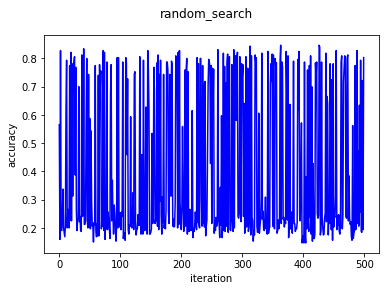

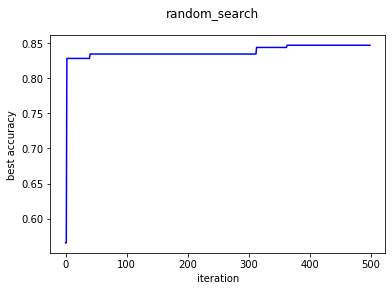

<module 'matplotlib.pyplot' from '//anaconda3/envs/AutoML_env/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [7]:
# We look at the tuning accuracy
rs_results.plot_accuracy_history()
rs_results.plot_accuracy_history(best_accuracy=True)

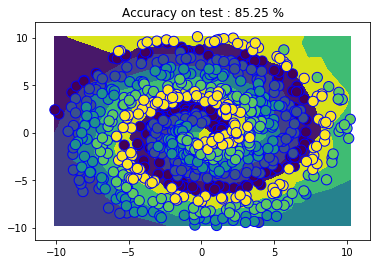

In [8]:
# We look at the score on test data set
mlp_for_rs.plot_data(x_test, t_test)

In [9]:
# We save all the results for this test
rs_results.save_all_results(results_path, experiment_title, dgen.model, 
                            dgen.train_size, mlp_for_rs.score(x_test, t_test), noise)


<Figure size 432x288 with 0 Axes>

## TPE (Tree-structured Parzen Estimator )

In [10]:
# We do a deep copy of our MLP for the test
mlp_for_tpe = pickle.loads(save)

In [11]:
# We initialize a tuner with tpe method and set our search space
tpe_tuner = HPtuner(mlp_for_tpe, 'tpe')
tpe_tuner.set_search_space({'alpha': ContinuousDomain(-8, 0, log_scaled=True),
                            'learning_rate_init': ContinuousDomain(-8, 0, log_scaled=True),
                            'batch_size': DiscreteDomain(list(linspace(50, 500, 10, dtype=int)))})


In [12]:
# We execute the tuning
tpe_results = tpe_tuner.tune(x_train, t_train, n_evals=nb_evals, nb_cross_validation=nb_cross_validation)

100%|██████████| 500/500 [32:26<00:00,  3.89s/it, best loss: 0.13437500000000002] 


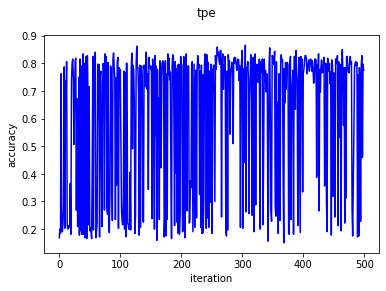

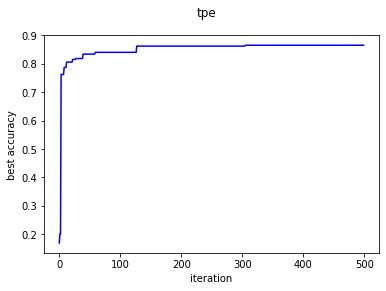

<module 'matplotlib.pyplot' from '//anaconda3/envs/AutoML_env/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [13]:
# We look at the tuning accuracy
tpe_results.plot_accuracy_history()
tpe_results.plot_accuracy_history(best_accuracy=True)

In [14]:
# We look at the score on test data set and save the results
mlp_for_tpe.plot_data(x_test, t_test)

In [15]:
# We save all the results for this test
tpe_results.save_all_results(results_path, experiment_title, dgen.model,
                             dgen.train_size, mlp_for_tpe.score(x_test, t_test), noise)


<Figure size 432x288 with 0 Axes>

## Standard GP with EI acquisition function

In [16]:
# We do a deep copy of our MLP for the test
mlp_for_GP = pickle.loads(save)

In [17]:
# We initialize a tuner with the standard GP method and set our search space
GP_tuner = HPtuner(mlp_for_GP, 'gaussian_process')
GP_tuner.set_search_space({'alpha': ContinuousDomain(-8, 0, log_scaled=True),
                           'learning_rate_init': ContinuousDomain(-8, 0, log_scaled=True),
                           'batch_size': DiscreteDomain(list(linspace(50, 500, 10, dtype=int)))})


In [18]:
# We execute the tuning using default parameter for GP 
# ('GP' as method type, 5 initial points to evaluate before the beginning and 'EI' acquisition)
GP_results = GP_tuner.tune(x_train, t_train, n_evals=nb_evals, nb_cross_validation=nb_cross_validation)

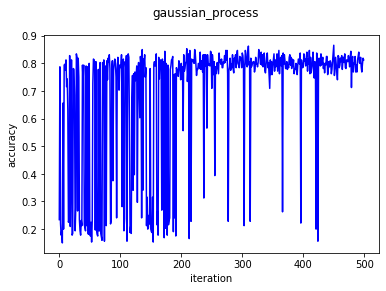

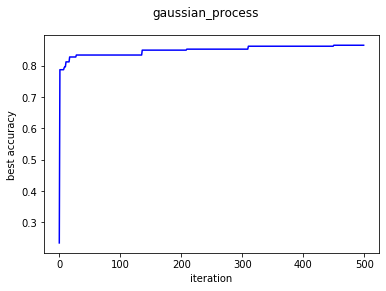

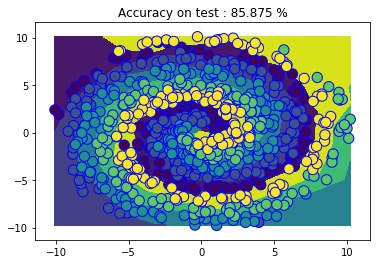

<Figure size 432x288 with 0 Axes>

In [19]:
# We look at the tuning accuracy, the score on test data set and save the results
GP_results.plot_accuracy_history()
GP_results.plot_accuracy_history(best_accuracy=True)
mlp_for_GP.plot_data(x_test, t_test)
GP_results.save_all_results(results_path, experiment_title, dgen.model,
                            dgen.train_size, mlp_for_GP.score(x_test,t_test), noise)


## Standard GP with MPI acquisition function

In [20]:
# We do a deep copy of our MLP for the test, initialize a tuner with the standard GP method and set our search space
mlp_for_GP2 = pickle.loads(save)
GP_tuner2 = HPtuner(mlp_for_GP2, 'gaussian_process')
GP_tuner2.set_search_space({'alpha': ContinuousDomain(-8, 0, log_scaled=True),
                            'learning_rate_init': ContinuousDomain(-8, 0, log_scaled=True),
                            'batch_size': DiscreteDomain(list(linspace(50, 500, 10, dtype=int)))})


In [21]:
# We execute the tuning using default parameter for GP except MPI acquisition
# ('GP' as method type, 5 initial points to evaluate before the beginning and 'MPI' acquisition)
GP_results2 = GP_tuner2.tune(x_train, t_train, n_evals=nb_evals,
                             nb_cross_validation=nb_cross_validation, acquisition_function='MPI')


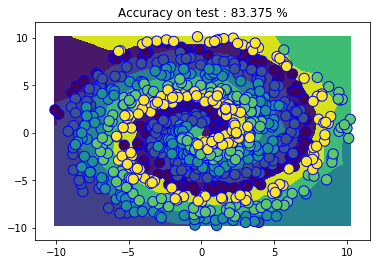

<Figure size 432x288 with 0 Axes>

In [22]:
# We look at the tuning accuracy, the score on test data set and save the results
GP_results2.plot_accuracy_history()
GP_results2.plot_accuracy_history(best_accuracy=True)
mlp_for_GP2.plot_data(x_test, t_test)
GP_results2.save_all_results(results_path, experiment_title, dgen.model,
                             dgen.train_size, mlp_for_GP2.score(x_test, t_test), noise)


## Grid search

In [23]:
# We do a deep copy of our MLP for the test, initialize a tuner with the standard GP method and set our search space
mlp_for_gs = pickle.loads(save)
gs_tuner = HPtuner(mlp_for_gs, 'grid_search')
gs_tuner.set_search_space({'alpha': DiscreteDomain(list(linspace(10**-8, 1, 10))),
                           'learning_rate_init': DiscreteDomain(list(linspace(10**-8, 1, 10))),
                           'batch_size': DiscreteDomain(list(linspace(100, 500, 5, dtype=int)))})


In [24]:
# We execute the tuning
gs_results = gs_tuner.tune(x_train, t_train, nb_cross_validation=nb_cross_validation)

100%|██████████| 500/500 [03:19<00:00,  8.26it/s, Best loss0.40312499999999996]

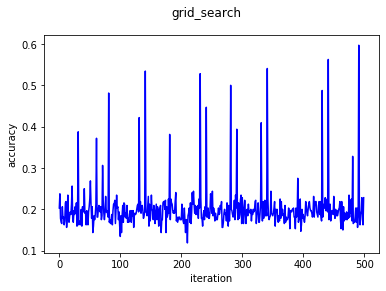

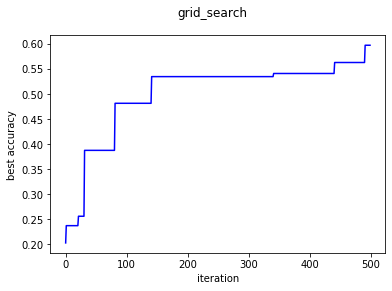

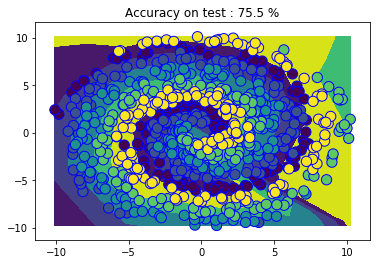

<Figure size 432x288 with 0 Axes>

In [25]:
# We look at the tuning accuracy, the score on test data set and save the results
gs_results.plot_accuracy_history()
gs_results.plot_accuracy_history(best_accuracy=True)
mlp_for_gs.plot_data(x_test, t_test)
gs_results.save_all_results(results_path, experiment_title, dgen.model,
                            dgen.train_size,  mlp_for_gs.score(x_test,t_test), noise)
